##Step1: Generating Data

In [86]:
import numpy as np
import pandas as pd


L1, L2, L3 = 17, 19, 23
num_samples = 20

theta1 = np.random.uniform(-np.pi, np.pi, num_samples)
theta2 = np.random.uniform(-np.pi, np.pi, num_samples)
theta3 = np.random.uniform(-np.pi, np.pi, num_samples)

data = []

for t1 in theta1:
    for t2 in theta2:
        for t3 in theta3:
            x = L1 * np.cos(t1) + L2 * np.cos(t1 + t2) + L3 * np.cos(t1 + t2 + t3)
            y = L1 * np.sin(t1) + L2 * np.sin(t1 + t2) + L3 * np.sin(t1 + t2 + t3)
            phi = t1 + t2 + t3
            data.append([x, y, phi, t1, t2, t3])
            if len(data) >= 400:
                break
        else:
            continue
        break
    else:
        continue
    break

df = pd.DataFrame(data, columns=['x', 'y', 'phi', 'theta1', 'theta2', 'theta3'])

#save in excel file
df.to_csv('ikp_dataset.csv', index=False)
print("Dataset saved to 'ikp_dataset.csv'.")


Dataset saved to 'ikp_dataset.csv'.


In [87]:
from google.colab import files
files.download('ikp_dataset.csv')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Load and prepare data set

In [88]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('ikp_dataset.csv')


X = df[['x', 'y', 'phi']].values
Y = df[['theta1', 'theta2', 'theta3']].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

# Shuffling
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)


Defined a fully connected neural network model with two hidden layers (each with 50 neurons) and an output layer with 3 neurons for the joint angles.

In [90]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3, 50)  #input size 3 cause:(x, y, phi), output size 50
        self.fc2 = nn.Linear(50, 50)  #input size 50, output size 50
        self.fc3 = nn.Linear(50, 3)  #input size 50, output size 3 cause:(theta1, theta2, theta3)

    def forward(self, x):
        x = torch.relu(self.fc1(x)) #relu
        x = torch.relu(self.fc2(x)) #relu
        x = self.fc3(x)  #linear activation for output
        return x

model = MLP()


In [91]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


In [92]:
num_epochs = 200
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * inputs.size(0)
    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')


Epoch [10/200], Loss: 1.0551
Epoch [20/200], Loss: 0.8848
Epoch [30/200], Loss: 0.7579
Epoch [40/200], Loss: 0.7010
Epoch [50/200], Loss: 0.6727
Epoch [60/200], Loss: 0.6151
Epoch [70/200], Loss: 0.5174
Epoch [80/200], Loss: 0.5285
Epoch [90/200], Loss: 0.4303
Epoch [100/200], Loss: 0.4377
Epoch [110/200], Loss: 0.3358
Epoch [120/200], Loss: 0.3622
Epoch [130/200], Loss: 0.3492
Epoch [140/200], Loss: 0.3499
Epoch [150/200], Loss: 0.3201
Epoch [160/200], Loss: 0.3178
Epoch [170/200], Loss: 0.2970
Epoch [180/200], Loss: 0.2980
Epoch [190/200], Loss: 0.2612
Epoch [200/200], Loss: 0.2722


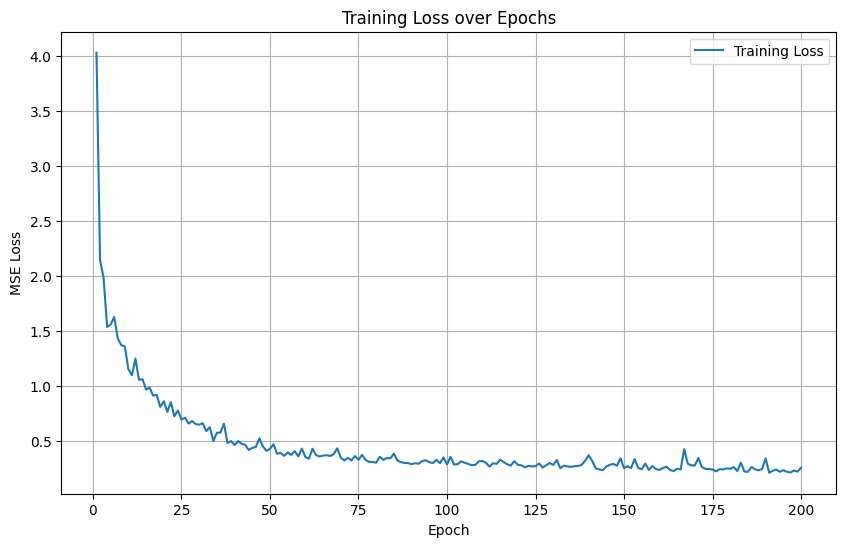

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()


In [93]:
import torch
import torch.nn as nn
import numpy as np


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 3)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def test_model(model, sample_input):

    input_tensor = torch.tensor(sample_input, dtype=torch.float32)


    model.eval()


    with torch.no_grad():

        output = model(input_tensor)

    return output.numpy()

if __name__ == '__main__':

    model = MLP()
    model.load_state_dict(torch.load('your_model_checkpoint.pth', map_location=torch.device('cpu')))


    sample_input = [[35.1476, 22.8052, 1.0651]]  # values for x, y, phi when t = 0


    predictions = test_model(model, sample_input)

    print('Predicted joint angles:')
    print(f'Theta1: {predictions[0, 0]:.4f}')
    print(f'Theta2: {predictions[0, 1]:.4f}')
    print(f'Theta3: {predictions[0, 2]:.4f}')


Predicted joint angles:
Theta1: 1.3290
Theta2: -1.2432
Theta3: -2.1534


In [102]:
theta1_rad = np.pi/4 + np.pi/9 * np.sin(np.pi/5 * 0)
theta2_rad = np.pi/6 + np.pi/18 * np.cos(np.pi/10 * 0)
theta3_rad = -np.pi/9 - np.pi/36 * np.sin(np.pi/15 * 0)

In [103]:
print(f"Theta1: {theta1_rad:.4f} radians")
print(f"Theta2: {theta2_rad:.4f} radians")
print(f"Theta3: {theta3_rad:.4f} radians")


Theta1: 0.7854 radians
Theta2: 0.6981 radians
Theta3: -0.3491 radians
